In [2]:
import cv2
import re
import easyocr
import pyttsx3
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
import warnings
warnings.filterwarnings('ignore')

In [3]:
engine = pyttsx3.init()

engine.setProperty('rate', 150)

engine.setProperty('volume', 0.8)

In [4]:
def siftFeatures(path):
    img = cv2.imread(path)
    gray = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (128, 128))
            
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return pd.DataFrame(descriptors).astype('uint8')

In [5]:
def featureReduction(features):
    modelKmeansA = joblib.load('./Trained_Models/SIFT_500_Behtar/Kmeans_A')#pickle.load(file)

    data = modelKmeansA.predict(features)
    hist = np.histogram(data,bins=7)

    return pd.DataFrame([hist[0]])

FrontBus


Using CPU. Note: This module is much faster with a GPU.


['CNI;' 'C264 EFab Kiaog' 'Foi6ts']

264


<function matplotlib.pyplot.show(close=None, block=None)>

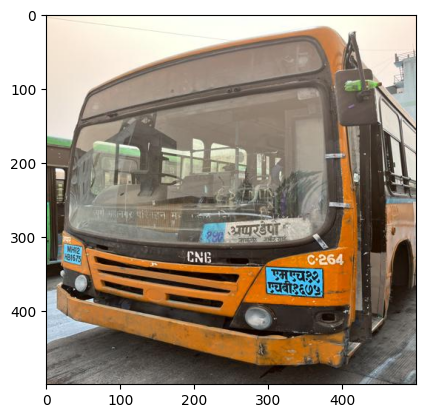

In [7]:
img_path = 'C:/Dataset/AD500_Behtar/FrontBus/IMG_3651.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/SIFT_500_Behtar/model_dt_A_tuning')
modelA_pred = modelA.predict(featureReduction(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["FrontBus", "InsideBus", "NotBus", "SideBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)

if predicted_label == 'FrontBus':
    engine.say("You are at the bus front")
    engine.runAndWait()
    engine.say("The bus number is: ")
    engine.runAndWait()
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(img,paragraph="False")
    result_array = np.array(result)
    last_column = result_array[:, -1]
    print(last_column)
    desired_string = ''
    for text in last_column:
        if 'marcopolo' in text.lower():
            parts = text.lower().split('marcopolo')
            if len(parts) == 2:
                desired_string = parts[0] + parts[1]
    print(desired_string)
    engine.say(desired_string)
    engine.runAndWait()
    for string in last_column:
        match = re.search(r'\d{3}', string)
        if match:
            numbers = match.group()
            print(numbers)
            engine.say(numbers)
            engine.runAndWait()
            
elif predicted_label == 'InsideBus':
    engine.say("You are inside the bus")
    engine.runAndWait()
    face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
    count=0
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        count=count+1
    seats=20-count
    print("Number of empty seats: " , 20 - count)
    engine.say("The total number of empty seats in the bus are: ")
    engine.runAndWait()
    engine.say(seats)
    engine.runAndWait()
    
elif predicted_label == 'SideBus':
    engine.say("You are at the bus entrance side")
    engine.runAndWait()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_value = 50
    _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_rectangular_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
            if len(approx) == 4:
                largest_area = area
                largest_rectangular_contour = approx

    if largest_rectangular_contour is not None:
        x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        center_x = x + w / 2
        center_y = y + h / 2
        image_center_x = image.shape[1] / 2
        if center_x < image_center_x - w / 2:
            res = 'Entry Door is on the left side'
        elif center_x > image_center_x + w / 2:
            res ='Entry Door is on the right side'
        else:
            res = 'Entry Door is in front'
    engine.say(res)
    engine.runAndWait()
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel =  np.zeros((1,65),np.float64)*255
    fgdModel =  np.zeros((1,65),np.float64)*255

    rect =	(134,150,660,730)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                cv2.GC_INIT_WITH_RECT)
    mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img  = img*mask2[:,:,np.newaxis]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

    horizontal_lines = []
    for line in lines:
        rho, theta = line[0]
        if theta == 0:
            horizontal_lines.append(line)

    count = 0
    for line in horizontal_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        count+=1

    print('Total Number of Steps : ' , count+1)
    engine.say("The total number of steps to get on the bus are: ")
    engine.runAndWait()
    engine.say(count + 1)
    engine.runAndWait()
else:
    engine.say("There is no bus")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/AD500_Behtar/FrontBus/IMG_3651.jpg')
plt.imshow (img_path)
plt.show

InsideBus
Number of empty seats:  15


<function matplotlib.pyplot.show(close=None, block=None)>

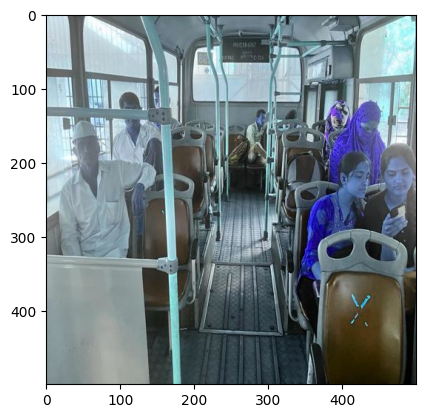

In [8]:
img_path = 'C:/Dataset/AD500_Behtar/InsideBus/resized_52.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/SIFT_500_Behtar/model_rf_A')
modelA_pred = modelA.predict(featureReduction(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["FrontBus", "InsideBus", "NotBus", "SideBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)

if predicted_label == 'FrontBus':
    engine.say("You are at the bus front")
    engine.runAndWait()
    engine.say("The bus number is: ")
    engine.runAndWait()
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(img,paragraph="False")
    result_array = np.array(result)
    last_column = result_array[:, -1]
    print(last_column)
    desired_string = ''
    for text in last_column:
        if 'marcopolo' in text.lower():
            parts = text.lower().split('marcopolo')
            if len(parts) == 2:
                desired_string = parts[0] + parts[1]
    print(desired_string)
    engine.say(desired_string)
    engine.runAndWait()
    for string in last_column:
        match = re.search(r'\d{3}', string)
        if match:
            numbers = match.group()
            print(numbers)
            engine.say(numbers)
            engine.runAndWait()
            
elif predicted_label == 'InsideBus':
    engine.say("You are inside the bus")
    engine.runAndWait()
    face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
    count=0
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        count=count+1
    seats=20-count
    print("Number of empty seats: " , 20 - count)
    engine.say("The total number of empty seats in the bus are: ")
    engine.runAndWait()
    engine.say(seats)
    engine.runAndWait()
    
elif predicted_label == 'SideBus':
    engine.say("You are at the bus entrance side")
    engine.runAndWait()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_value = 50
    _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_rectangular_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
            if len(approx) == 4:
                largest_area = area
                largest_rectangular_contour = approx

    if largest_rectangular_contour is not None:
        x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        center_x = x + w / 2
        center_y = y + h / 2
        image_center_x = image.shape[1] / 2
        if center_x < image_center_x - w / 2:
            res = 'Entry Door is on the left side'
        elif center_x > image_center_x + w / 2:
            res ='Entry Door is on the right side'
        else:
            res = 'Entry Door is in front'
    engine.say(res)
    engine.runAndWait()
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel =  np.zeros((1,65),np.float64)*255
    fgdModel =  np.zeros((1,65),np.float64)*255

    rect =	(134,150,660,730)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                cv2.GC_INIT_WITH_RECT)
    mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img  = img*mask2[:,:,np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

    horizontal_lines = []
    for line in lines:
        rho, theta = line[0]
        if theta == 0:
            horizontal_lines.append(line)

    count = 0
    for line in horizontal_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        count+=1
    print('Total Number of Steps : ' , count+1)
    engine.say("The total number of steps to get on the bus are: ")
    engine.runAndWait()
    engine.say(count + 1)
    engine.runAndWait()
else:
    engine.say("There is no bus")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/AD500_Behtar/InsideBus/resized_52.jpg')
plt.imshow (img_path)
plt.show

SideBus
Total Number of Steps :  3


<function matplotlib.pyplot.show(close=None, block=None)>

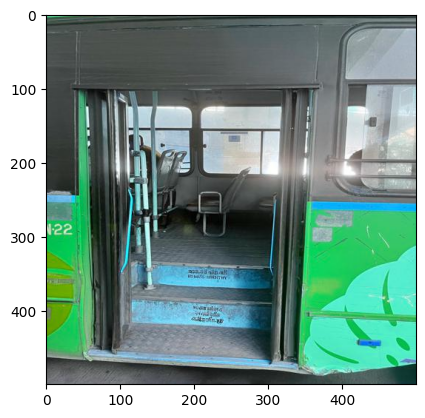

In [9]:
img_path = 'C:/Dataset/AD500_Behtar/SideBus/resized_34.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/SIFT_500_Behtar/model_dt_A')
modelA_pred = modelA.predict(featureReduction(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["FrontBus", "InsideBus", "NotBus", "SideBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)

if predicted_label == 'FrontBus':
    engine.say("You are at the bus front")
    engine.runAndWait()
    engine.say("The bus number is: ")
    engine.runAndWait()
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(img,paragraph="False")
    result_array = np.array(result)
    last_column = result_array[:, -1]
    print(last_column)
    desired_string = ''
    for text in last_column:
        if 'marcopolo' in text.lower():
            parts = text.lower().split('marcopolo')
            if len(parts) == 2:
                desired_string = parts[0] + parts[1]
    print(desired_string)
    engine.say(desired_string)
    engine.runAndWait()
    for string in last_column:
        match = re.search(r'\d{3}', string)
        if match:
            numbers = match.group()
            print(numbers)
            engine.say(numbers)
            engine.runAndWait()
            
elif predicted_label == 'InsideBus':
    engine.say("You are inside the bus")
    engine.runAndWait()
    face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
    count=0
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        count=count+1
    seats=20-count
    print("Number of empty seats: " , 20 - count)
    engine.say("The total number of empty seats in the bus are: ")
    engine.runAndWait()
    engine.say(seats)
    engine.runAndWait()
    
elif predicted_label == 'SideBus':
    engine.say("You are at the bus entrance side")
    engine.runAndWait()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_value = 50
    _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_rectangular_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
            if len(approx) == 4:
                largest_area = area
                largest_rectangular_contour = approx

    if largest_rectangular_contour is not None:
        x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        center_x = x + w / 2
        center_y = y + h / 2
        image_center_x = img.shape[1] / 2
        if center_x < image_center_x - w / 2:
            res = 'Entry Door is on the left side'
        elif center_x > image_center_x + w / 2:
            res ='Entry Door is on the right side'
        else:
            res = 'Entry Door is in front'
    engine.say(res)
    engine.runAndWait()
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel =  np.zeros((1,65),np.float64)*255
    fgdModel =  np.zeros((1,65),np.float64)*255

    rect =	(134,150,660,730)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                cv2.GC_INIT_WITH_RECT)
    mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img  = img*mask2[:,:,np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

    horizontal_lines = []
    for line in lines:
        rho, theta = line[0]
        if theta == 0:
            horizontal_lines.append(line)

    count = 0
    for line in horizontal_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        count+=1
    print('Total Number of Steps : ' , count+1)
    engine.say("The total number of steps to get on the bus are: ")
    engine.runAndWait()
    engine.say(count + 1)
    engine.runAndWait()
else:
    engine.say("There is no bus")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/AD500_Behtar/SideBus/resized_34.jpg')
plt.imshow (img_path)
plt.show

In [10]:
img_path = 'C:/Dataset/AD500_Behtar/NotBus/IMG_3956.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/SIFT_500_Behtar/model_dt_A_tuning')
modelA_pred = modelA.predict(featureReduction(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["FrontBus", "InsideBus", "NotBus", "SideBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)

if predicted_label == 'FrontBus':
    engine.say("You are at the bus front")
    engine.runAndWait()
    engine.say("The bus number is: ")
    engine.runAndWait()
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(img,paragraph="False")
    result_array = np.array(result)
    last_column = result_array[:, -1]
    print(last_column)
    desired_string = ''
    for text in last_column:
        if 'marcopolo' in text.lower():
            parts = text.lower().split('marcopolo')
            if len(parts) == 2:
                desired_string = parts[0] + parts[1]
    print(desired_string)
    engine.say(desired_string)
    engine.runAndWait()
    for string in last_column:
        match = re.search(r'\d{3}', string)
        if match:
            numbers = match.group()
            print(numbers)
            engine.say(numbers)
            engine.runAndWait()
            
elif predicted_label == 'InsideBus':
    engine.say("You are inside the bus")
    engine.runAndWait()
    face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
    count=0
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        count=count+1
    seats=20-count
    print("Number of empty seats: " , 20 - count)
    engine.say("The total number of empty seats in the bus are: ")
    engine.runAndWait()
    engine.say(seats)
    engine.runAndWait()
    
elif predicted_label == 'SideBus':
    engine.say("You are at the bus entrance side")
    engine.runAndWait()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_value = 50
    _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_rectangular_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
            if len(approx) == 4:
                largest_area = area
                largest_rectangular_contour = approx

    if largest_rectangular_contour is not None:
        x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        center_x = x + w / 2
        center_y = y + h / 2
        image_center_x = img.shape[1] / 2
        if center_x < image_center_x - w / 2:
            res = 'Entry Door is on the left side'
        elif center_x > image_center_x + w / 2:
            res ='Entry Door is on the right side'
        else:
            res = 'Entry Door is in front'
    engine.say(res)
    engine.runAndWait()
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel =  np.zeros((1,65),np.float64)*255
    fgdModel =  np.zeros((1,65),np.float64)*255

    #parameter(img,mask,rect,bgmodel,fgmodel,iter,method) 
    rect =	(134,150,660,730)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                cv2.GC_INIT_WITH_RECT)
    mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img  = img*mask2[:,:,np.newaxis]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

    horizontal_lines = []
    for line in lines:
        rho, theta = line[0]
        if theta == 0:
            horizontal_lines.append(line)

    count = 0
    for line in horizontal_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        count+=1

    print('Total Number of Steps : ' , count+1)
    engine.say("The total number of steps to get on the bus are: ")
    engine.runAndWait()
    engine.say(count + 1)
    engine.runAndWait()
else:
    engine.say("There is no bus")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/AD500_Behtar/NotBus/IMG_3956.jpg')
plt.imshow (img_path)
plt.show

FrontBus


Using CPU. Note: This module is much faster with a GPU.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed